In [1]:
import h5py
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
%matplotlib inline 
import seaborn

torch.cuda.empty_cache()

pathOfmodel="/home/mena/jupterFiles/F/hybird/128AA_H"

def show_tensor_images(epoch,index,image_tensor, num_images=13, size=(1, 28, 28),show=True,RealOrFake=True,ep=1):

    sample_dir=pathOfmodel            
    if(RealOrFake):
        fake_fname = 'Real-images-epoch{0:0=4d}_step{1:0=4d}.png'.format(epoch,index)
    else:
        fake_fname = 'Fake-images-epoch{0:0=4d}_step{1:0=4d}.png'.format(epoch,index)
    fig, axes = plt.subplots(nrows=3,ncols=3, figsize=(50,50))
    im=[1,2,3,4,5,6,7,8,9,10]
    index=0
    for i in range(3):
        for j in range(3):
            im[index] = axes[i,j].matshow(image_tensor[index].to("cpu").view(image_size,image_size).detach().numpy(),cmap="rocket")
            fig.colorbar(im[index], ax=axes[i,j])
            index+=1
    fig.savefig(os.path.join(sample_dir, fake_fname))
    print("")
    plt.close()
    print('Saving', fake_fname)

In [2]:


def conv_block(in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
        nn.BatchNorm2d(out_channels), 
        nn.LeakyReLU(0.2, inplace=True)]
        if pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)
        
class Generator64(nn.Module):
	def __init__(self, ngpu):
		super(Generator64, self).__init__()
		self.conv1 =nn.Sequential(nn.ConvTranspose2d(100, 512, kernel_size=4, stride=1, padding=0, bias=False),
                        nn.BatchNorm2d(512),#4
                        nn.LeakyReLU(0.2, inplace=True))
		self.conv2 = nn.Sequential(nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
                                    nn.BatchNorm2d(256),#8
                                    nn.LeakyReLU(0.2, inplace=True))
        
		self.res1 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        
		self.conv3 =nn.Sequential(nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
                                    nn.BatchNorm2d(128),#44
                                    nn.LeakyReLU(0.2, inplace=True))
		self.conv4 =nn.Sequential(nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
                                            nn.BatchNorm2d(64))#90
		self.res2 = nn.Sequential(conv_block(64, 64), conv_block(64, 64))
		self.conv5=nn.Sequential(   nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False))


	def forward(self, input):
		out = self.conv1(input)
		out = self.conv2(out)
		out = self.res1(out) + out
		out = self.conv3(out)
		out = self.conv4(out)
		out = self.res2(out) + out
		out = self.conv5(out)
		return out      
    
class Generator128(nn.Module):
	def __init__(self, ngpu):
		super(Generator128, self).__init__()
		self.conv1 =nn.Sequential(nn.ConvTranspose2d(100, 512, kernel_size=4, stride=4, padding=0, bias=False),
                        nn.BatchNorm2d(512),
                        nn.LeakyReLU(0.2, inplace=True))
		self.conv2 = nn.Sequential(nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
                                    nn.BatchNorm2d(256),
                                    nn.LeakyReLU(0.2, inplace=True))
        
		self.res1 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        
		self.conv3 =nn.Sequential(nn.ConvTranspose2d(256, 128, kernel_size=4, stride=4, padding=0, bias=False),
                                    nn.BatchNorm2d(128),
                                    nn.LeakyReLU(0.2, inplace=True))
		self.conv4 =nn.Sequential(nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
                                            nn.BatchNorm2d(64))
		self.res2 = nn.Sequential(conv_block(64, 64), conv_block(64, 64))
		self.conv5=nn.Sequential(   nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False))


	def forward(self, input):
		out = self.conv1(input)
		out = self.conv2(out)
		out = self.res1(out) + out
		out = self.conv3(out)
		out = self.conv4(out)
		out = self.res2(out) + out
		out = self.conv5(out)
		return out
    

class Generator256(nn.Module):
	def __init__(self, ngpu):
		super(Generator256, self).__init__()
		#self.ngpu = ngpu        #1
		self.conv1 =nn.Sequential(nn.ConvTranspose2d(100, 512, kernel_size=4, stride=4, padding=0, bias=False),
                        nn.BatchNorm2d(512),#4
                        nn.LeakyReLU(0.2, inplace=True))
		self.conv2 = nn.Sequential(nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
                                    nn.BatchNorm2d(256),#8
                                    nn.LeakyReLU(0.2, inplace=True))
        
		self.res1 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        
		self.conv3 =nn.Sequential(nn.ConvTranspose2d(256, 128, kernel_size=4, stride=4, padding=0, bias=False),
                                    nn.BatchNorm2d(128),#32
                                    nn.LeakyReLU(0.2, inplace=True))
		self.conv4 =nn.Sequential(nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
                                            nn.BatchNorm2d(64))#64
		self.res2 = nn.Sequential(conv_block(64, 64), conv_block(64, 64))
		self.conv5=nn.Sequential(   nn.ConvTranspose2d(64, 1, kernel_size=4, stride=4, padding=0, bias=False))


	def forward(self, input):
		out = self.conv1(input)
		out = self.conv2(out)
		out = self.res1(out) + out
		out = self.conv3(out)
		out = self.conv4(out)
		out = self.res2(out) + out
		out = self.conv5(out)
		return out
    
def get_noise(n_samples, z_dim=100, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device).reshape(n_samples,z_dim,1,1)

In [3]:
def convT_block(in_channels, out_channels, pool=False):
        layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, padding=1), 
        nn.BatchNorm2d(out_channels), 
        nn.LeakyReLU(0.2, inplace=True)]
        if pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)

class Critic64(nn.Module):
	def __init__(self, ngpu):
		super(Critic64, self).__init__()
		self.conv1=nn.Sequential(nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
                                nn.LeakyReLU(0.2, inplace=True),
                                nn.Dropout(0.1))

		self.conv2=nn.Sequential(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
                                    nn.BatchNorm2d(128),
                                    nn.LeakyReLU(0.2, inplace=True),
                                    nn.Dropout(0.1))
		self.conv3=nn.Sequential(nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
                                nn.BatchNorm2d(256),
                                nn.LeakyReLU(0.2, inplace=True),
                                nn.Dropout(0.1))
		self.conv4=nn.Sequential(nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
                                    nn.BatchNorm2d(512),
                                    nn.LeakyReLU(0.2, inplace=True),
                                    nn.Dropout(0.1))
		self.conv5=nn.Sequential(nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False)
                                )
		
	def forward(self, input):
		out = self.conv1(input)
		out = self.conv2(out)
		out = self.conv3(out)
		out = self.conv4(out)
		out = self.conv5(out)
		return out
    

class Critic128(nn.Module):
	def __init__(self, ngpu):
		super(Critic128, self).__init__()
		self.conv1=nn.Sequential(nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
                                nn.LeakyReLU(0.2, inplace=True),
                                nn.Dropout(0.1))

		self.conv2=nn.Sequential(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
                                    nn.BatchNorm2d(128),
                                    nn.LeakyReLU(0.2, inplace=True),
                                    nn.Dropout(0.1))
		self.conv3=nn.Sequential(nn.Conv2d(128, 256, kernel_size=4, stride=4, padding=1, bias=False),
                                nn.BatchNorm2d(256),
                                nn.LeakyReLU(0.2, inplace=True),
                                nn.Dropout(0.1))
		self.conv4=nn.Sequential(nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
                                    nn.BatchNorm2d(512),
                                    nn.LeakyReLU(0.2, inplace=True),
                                    nn.Dropout(0.1))
		self.conv5=nn.Sequential(nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False)
                                )
		
	def forward(self, input):
		out = self.conv1(input)
		out = self.conv2(out)
		out = self.conv3(out)
		out = self.conv4(out)
		out = self.conv5(out)
		return out    
    
class Critic256(nn.Module):
	def __init__(self, ngpu):
		super(Critic256, self).__init__(
		self.conv1=nn.Sequential(nn.Conv2d(1, 64, kernel_size=4, stride=4, padding=0, bias=False),
                                nn.LeakyReLU(0.2, inplace=True),
                                nn.Dropout(0.1))

		self.conv2=nn.Sequential(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
                                    nn.BatchNorm2d(128),
                                    nn.LeakyReLU(0.2, inplace=True),
                                    nn.Dropout(0.1))
		self.conv3=nn.Sequential(nn.Conv2d(128, 256, kernel_size=4, stride=4, padding=1, bias=False),
                                nn.BatchNorm2d(256),
                                nn.LeakyReLU(0.2, inplace=True),
                                nn.Dropout(0.1))
		self.conv4=nn.Sequential(nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
                                    nn.BatchNorm2d(512),
                                    nn.LeakyReLU(0.2, inplace=True),
                                    nn.Dropout(0.1))
		self.conv5=nn.Sequential(nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False)
                                )
		
	def forward(self, input):
		out = self.conv1(input)
		out = self.conv2(out)
		out = self.conv3(out)
		out = self.conv4(out)
		out = self.conv5(out)
		return out

In [4]:
torch.set_default_dtype(torch.float32)

n_epochs = 100
z_dim = 100
display_step =1543*5
lr = 0.0001
batch_size = 64
image_size=128

beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5
device = 'cuda:1'

data_path="/home/mena/dataSets/dataset.hdf5"

with h5py.File(data_path, "r") as data_file:
    x = data_file[f"train_{image_size}"][:]
data_len = len(x)
print(data_len)
dataloader = DataLoader(x, batch_size=batch_size, shuffle=True,)

98748


In [5]:
gen = Generator128(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Critic128(1).to(device) 
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)


# Function to calculate the characteristic of the protein's structure distance matrix.
### BackBone on natural protein 3.78A
### Short on natural protein 7.5A
### Long on natural protein 20.31A for 128 aa

In [6]:

def ckeckBackBone(fake_images,image_size=image_size,batch_size=13):#4
    #BackBone
    sum=0
    avgBatch=0
    batch=batch_size
    for b in range(batch):
        for i in range(image_size):
            for j in range(i+1,image_size):
                sum+=fake_images[b][0][i][j]
                break
        avgPeptiedBond=(sum/image_size)
        sum=0
        #print("avg peptide bond protien",b," : " ,avgPeptiedBond)
        avgBatch+=avgPeptiedBond
    print("avg peptide bond BackBone protien for batch" ,(avgBatch/batch))



def ckeckshort(fake_images,image_size=image_size,batch_size=13):#10
    #short
    avgBatch=0
    batch=batch_size
    imgSize_4=(image_size-4)
    for b in range(batch):
        sum=0
        for i in range(image_size):
            for j in range(i,imgSize_4,4):
                #print("distance(",i,",",j,") :",s)
                sum+=(fake_images[b][0][i][j+2]+fake_images[b][0][i][j+3]+fake_images[b][0][i][j+4])/3
                break
        avgPeptiedBond=(sum/imgSize_4)
        #print("avg peptide bond protien",b," : " ,avgPeptiedBond)
        avgBatch+=avgPeptiedBond
    print("avg peptide bond short protien for batch" ,(avgBatch/batch))
    


def ckeckLong(fake_images,image_size=image_size,batch_size=13):#20
    #Long
    batch=batch_size
    bsum=0
    c=0
    for b in range(batch):
        msum=0
        for i in range(image_size-5):
            sum=0
            for j in range(i+5,(image_size)):
                sum+=fake_images[b][0][i][j]
            sum/=(j+1-(i+5))
            msum+=sum
        bsum+=(msum/image_size)
    print("avg peptide bond Long protien for batch" ,(bsum/batch))
    return (bsum/batch)

def show_image(fake_images,index=0,image_size=image_size):
    import seaborn as sns
    sns.heatmap((fake_images[index].view(image_size,image_size).detach().numpy()))

def Bhattacharyya(arrOfx,arrOfy):
    with torch.no_grad():
        #print(torch.sqrt((arrOfx/torch.sum(arrOfx))*(arrOfy/torch.sum(arrOfy))).shape)
        print(torch.nansum(torch.sqrt((arrOfx/torch.sum(arrOfx))*(arrOfy/torch.sum(arrOfy)))))
        return 1-torch.log(torch.nansum(torch.sqrt((arrOfx/torch.sum(arrOfx))*(arrOfy/torch.sum(arrOfy)))))



# natural

torch.Size([64, 1, 128, 128])
torch.Size([128, 128])
mean tensor(22.4008, dtype=torch.float64)
avg peptide bond BackBone protien for batch tensor(3.7916, dtype=torch.float64)
avg peptide bond short protien for batch tensor(7.6294, dtype=torch.float64)
avg peptide bond Long protien for batch tensor(21.3458, dtype=torch.float64)


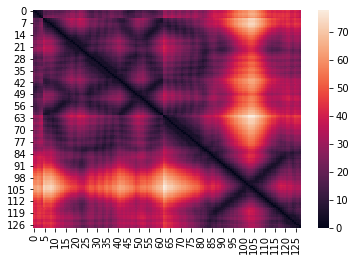

In [7]:
for d in dataloader:
    d1=d.reshape(batch_size,1,image_size,image_size)
    print(d1.shape)
    print(d1[3][0].shape)
    print("mean",torch.mean(d1[0][0]))
    show_image(d1,index=3)
    ckeckBackBone(d1,image_size=image_size,batch_size=batch_size)
    ckeckshort(d1,image_size=image_size,batch_size=batch_size)
    ckeckLong(d1,image_size=image_size,batch_size=batch_size)
    #Bhattacharyya(torch.tensor(Tx).reshape(128,1,128,128),fake_images_test)

    break
    

totalAvgOfSum=[]
count=0
for d in dataloader:
    totalAvgOfSum.append(torch.sum(d)/batch_size)
    count=count+1
avgOfSum_AllLen=sum(totalAvgOfSum)/len(totalAvgOfSum)
print(avgOfSum_AllLen)#=torch.tensor(335191.2124)###256--->tensor(1774851.7051, dtype=torch.float64)

# Calculate the average distance of all distance matrices of protein structure


In [8]:
totalMeanOfSumBatch=[]
for d in dataloader:
    totalMeanOfSumBatch.append(torch.sum(d)/batch_size)
meanOfSum_AllBatch=sum(totalMeanOfSumBatch)/len(totalMeanOfSumBatch)
print(meanOfSum_AllBatch)#=torch.tensor(335191.2124)###256--->tensor(1774851.7051, dtype=torch.float64)

tensor(375434.3694, dtype=torch.float64)


In [9]:
totalMeanOfSumBatch.sort()

In [10]:
totalMeanOfSumBatch

[tensor(351141.4474, dtype=torch.float64),
 tensor(351998.6911, dtype=torch.float64),
 tensor(352250.0390, dtype=torch.float64),
 tensor(352620.0118, dtype=torch.float64),
 tensor(353183.9036, dtype=torch.float64),
 tensor(353436.5999, dtype=torch.float64),
 tensor(354069.3484, dtype=torch.float64),
 tensor(354370.4720, dtype=torch.float64),
 tensor(355134.0000, dtype=torch.float64),
 tensor(355853.3929, dtype=torch.float64),
 tensor(356031.2397, dtype=torch.float64),
 tensor(356395.3993, dtype=torch.float64),
 tensor(356758.9304, dtype=torch.float64),
 tensor(356759.6767, dtype=torch.float64),
 tensor(356855.2888, dtype=torch.float64),
 tensor(356888.0846, dtype=torch.float64),
 tensor(356918.8592, dtype=torch.float64),
 tensor(357307.7665, dtype=torch.float64),
 tensor(357335.2792, dtype=torch.float64),
 tensor(357626.6940, dtype=torch.float64),
 tensor(357746.1981, dtype=torch.float64),
 tensor(357825.9521, dtype=torch.float64),
 tensor(357995.5203, dtype=torch.float64),
 tensor(358

In [19]:





#############Me################
import os
import numpy as np
import torch
import torch.nn as nn
from collections import OrderedDict
from torchvision.models import vgg19

class VGG_FeatureExtractor(nn.Module):
    def __init__(self):
        super(VGG_FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:35])

    def forward(self, x):
        out = self.feature_extractor(x)
        return out

feature_extractor=VGG_FeatureExtractor().to(device) 

sp_criterion=torch.nn.L1Loss()
DistByDist_criterion=torch.nn.L1Loss()
criterion_sharpLoss = torch.nn.MSELoss().to("cuda")

def p_loss( fake, real):
    fake = fake.repeat(1,3,1,1)
    real = real.repeat(1,3,1,1)
    fake_feature = feature_extractor(fake)
    real_feature = feature_extractor(real)
    loss = sp_criterion(fake_feature, real_feature)
    return loss


import pytorch_msssim
def MSSSIM_loss(real,fake):
    m = pytorch_msssim.MS_SSIM()
    print(pytorch_msssim.ssim(real, fake))
    


In [20]:
#!pip install pytorch_msssim

In [22]:
for d in dataloader:
    d1=d.reshape(batch_size,1,image_size,image_size)
    print(d1.shape)
    print(torch.sum(torch.sum(torch.sum(torch.sum(d1))))/batch_size)
    print(torch.sum(d1)/batch_size)
    break
    

torch.Size([64, 1, 128, 128])
tensor(375255.2476, dtype=torch.float64)
tensor(375255.2476, dtype=torch.float64)


In [23]:
#print(avg_AllLen)#=torch.tensor(335191.2124)
#avg_AllLen=torch.tensor(avg_AllLen)


def get_gradient(crit, real, fake, epsilon):
    # Mix the images together
    sumF=(torch.sum(fake)/batch_size)     
    if torch.isclose(sumF, meanOfSum_AllBatch, atol=375434.3694):
        mixed_images = real * epsilon + fake * (1 - epsilon) 
    else:
        mixed_images = real * epsilon + fake *(meanOfSum_AllBatch/sumF)* (1 - epsilon)
    mixed_scores = crit(mixed_images)
    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient


In [24]:
def test_get_gradient(image_shape):
    real = torch.randn(*image_shape, device=device) + 1
    fake = torch.randn(*image_shape, device=device) - 1
    epsilon_shape = [1 for _ in image_shape]
    epsilon_shape[0] = image_shape[0]
    epsilon = torch.rand(epsilon_shape, device=device).requires_grad_()
    gradient = get_gradient(crit, real, fake, epsilon)
    assert tuple(gradient.shape) == image_shape
    assert gradient.max() > 0
    assert gradient.min() < 0
    return gradient

gradient = test_get_gradient((batch_size, 1, image_size, image_size))#((256, 1, 28, 28))
print("Success!")

Success!


In [25]:
def gradient_penalty(gradient):
    gradient = gradient.view(len(gradient), -1)
    gradient_norm = gradient.norm(2, dim=1)
    penalty = (torch.mean(gradient_norm)-1)**2
    return penalty

In [26]:
# UNIT TEST
def test_gradient_penalty(image_shape):
    bad_gradient = torch.zeros(*image_shape)
    bad_gradient_penalty = gradient_penalty(bad_gradient)
    assert torch.isclose(bad_gradient_penalty, torch.tensor(1.))

    image_size = torch.prod(torch.Tensor(image_shape[1:]))
    good_gradient = torch.ones(*image_shape) / torch.sqrt(image_size)
    good_gradient_penalty = gradient_penalty(good_gradient)
    assert torch.isclose(good_gradient_penalty, torch.tensor(0.))

    random_gradient = test_get_gradient(image_shape)
    random_gradient_penalty = gradient_penalty(random_gradient)
    assert torch.abs(random_gradient_penalty - 1) < 0.15

test_gradient_penalty((batch_size, 1, image_size, image_size))#((128, 1, 128, 128))#((256, 1, 28, 28))
print("Success!")

Success!


In [27]:
def get_gen_loss(crit_fake_pred):
    gen_loss = -1. * torch.mean(crit_fake_pred)
    return gen_loss

In [28]:
# UNIT TEST
assert torch.isclose( get_gen_loss(torch.tensor(1.)), torch.tensor(-1.0)  )

assert torch.isclose( get_gen_loss(torch.rand(10000)), torch.tensor(-0.5), 0.05 )

print("Success!")

Success!


In [29]:

def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    crit_loss =torch.mean(crit_fake_pred)-torch.mean(crit_real_pred)+c_lambda*gp
    return crit_loss

In [30]:
# UNIT TEST
assert torch.isclose(
    get_crit_loss(torch.tensor(1.), torch.tensor(2.), torch.tensor(3.), 0.1),
    torch.tensor(-0.7)
)

assert torch.isclose(
    get_crit_loss(torch.tensor(20.), torch.tensor(-20.), torch.tensor(2.), 10),
    torch.tensor(60.)
)

print("Success!")

Success!


In [33]:
parGLoss=0.05
parVGGLoss=0.0995
parSSIMLoss=100
parDistByDistLoss=0.95


# To pure model set all parameters to zero " don't calculate it".
### parVGGLoss=0
### parSSIMLoss=0
### parDistByDistLoss=0

start 2021-12-16 09:56:58.210809


  0%|          | 0/100 [00:00<?, ?it/s]

epoch :  0


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  1


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  2


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  3


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  4


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  5


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch 5:Step 7715:  Total Generator loss: 222.80549021824103, critic loss: -895.1084685086627,Generator loss: 3464.008788248937, VGG ploss mean : 12.375795970701661, SSIM loss mean : 0.36576858687076336 

Saving Fake-images-epoch0005_step7715.png

Saving Real-images-epoch0005_step7715.png


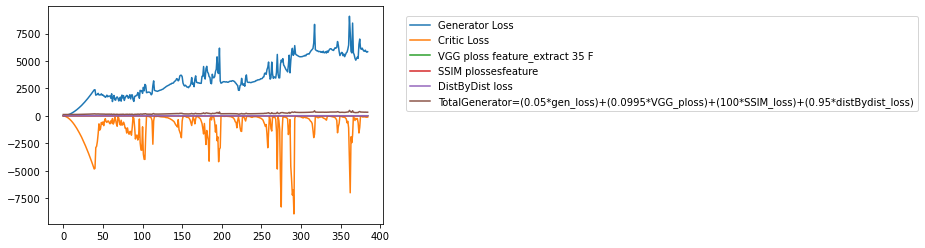

epoch :  6


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  7


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  8


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  9


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  10


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch 10:Step 15430:  Total Generator loss: 833.3200812152509, critic loss: -4245.3802341846595,Generator loss: 15876.412686643767, VGG ploss mean : 10.295765072914662, SSIM loss mean : 0.2877963499596423 

Saving Fake-images-epoch0010_step15430.png

Saving Real-images-epoch0010_step15430.png


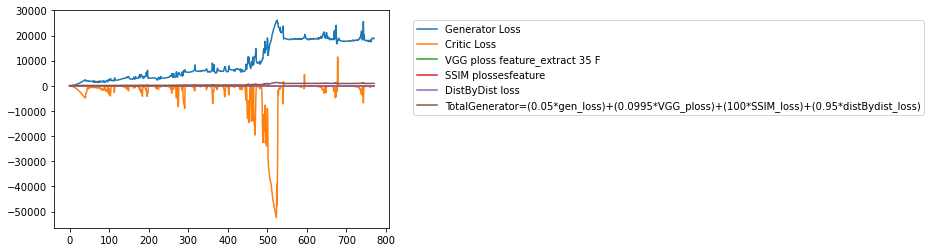

epoch :  11


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  12


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  13


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  14


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  15


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch 15:Step 23145:  Total Generator loss: 939.0720212788066, critic loss: -919.0087714713114,Generator loss: 17992.693164899112, VGG ploss mean : 9.881660269454787, SSIM loss mean : 0.2879753469802772 

Saving Fake-images-epoch0015_step23145.png

Saving Real-images-epoch0015_step23145.png


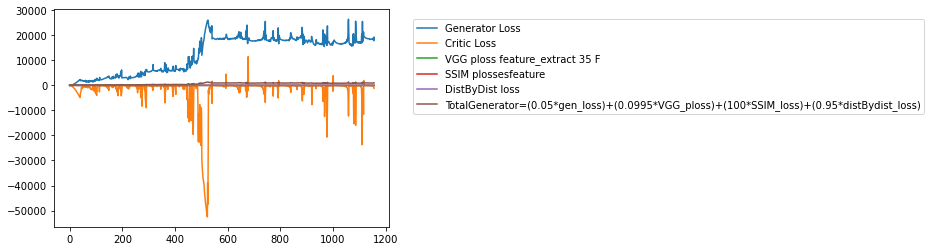

epoch :  16


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  17


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  18


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  19


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  20


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch 20:Step 30860:  Total Generator loss: 1028.9857459038012, critic loss: -1184.666478443507,Generator loss: 19792.5714393502, VGG ploss mean : 9.839779229204298, SSIM loss mean : 0.28728149415453147 

Saving Fake-images-epoch0020_step30860.png

Saving Real-images-epoch0020_step30860.png


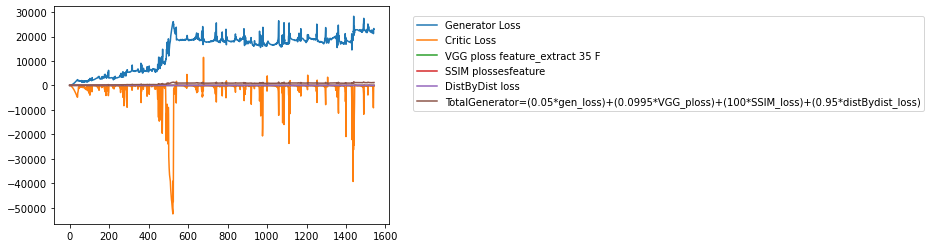

epoch :  21


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  22


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  23


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  24


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  25


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch 25:Step 38575:  Total Generator loss: 1391.81518351888, critic loss: -1318.2039666480052,Generator loss: 27047.7998192679, VGG ploss mean : 10.00656733176033, SSIM loss mean : 0.2878218239572862 

Saving Fake-images-epoch0025_step38575.png

Saving Real-images-epoch0025_step38575.png


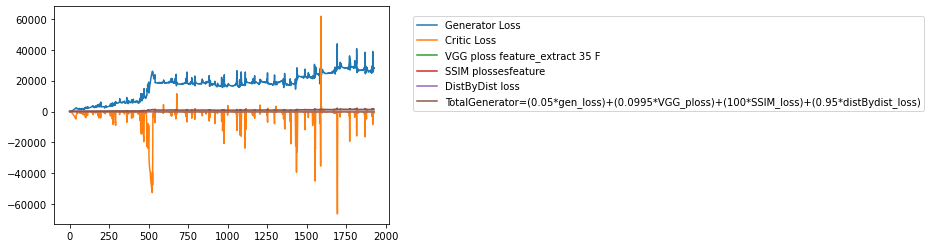

epoch :  26


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  27


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  28


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  29


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  30


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch 30:Step 46290:  Total Generator loss: 1428.9691183254615, critic loss: -822.5084508413057,Generator loss: 27772.52091133083, VGG ploss mean : 10.241434445384256, SSIM loss mean : 0.29574252080392005 

Saving Fake-images-epoch0030_step46290.png

Saving Real-images-epoch0030_step46290.png


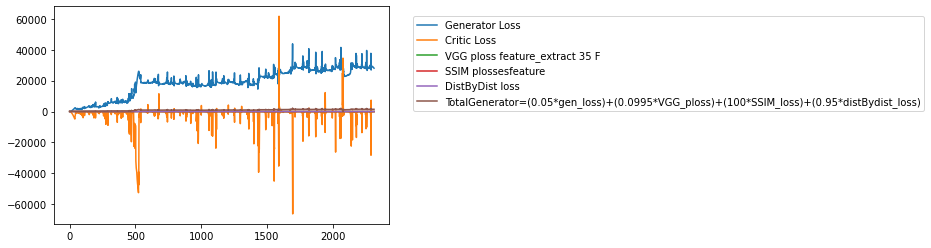

epoch :  31


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  32


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  33


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  34


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  35


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch 35:Step 54005:  Total Generator loss: -651.365211624274, critic loss: 528.1572637090005,Generator loss: -13811.129846258651, VGG ploss mean : 9.818453759955494, SSIM loss mean : 0.2857843060811773 

Saving Fake-images-epoch0035_step54005.png

Saving Real-images-epoch0035_step54005.png


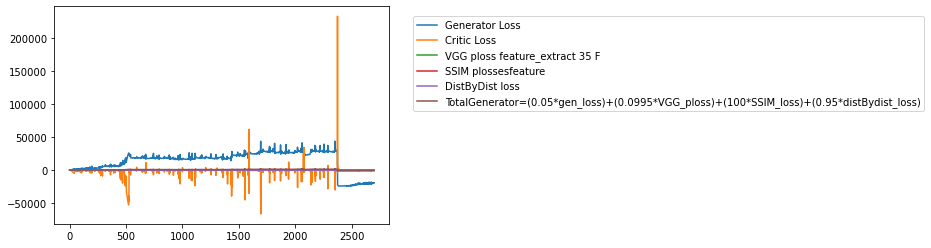

epoch :  36


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  37


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  38


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  39


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  40


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch 40:Step 61720:  Total Generator loss: -786.2077966452727, critic loss: -273.7902001709856,Generator loss: -16511.902457731077, VGG ploss mean : 9.7221873670913, SSIM loss mean : 0.28776795106975583 

Saving Fake-images-epoch0040_step61720.png

Saving Real-images-epoch0040_step61720.png


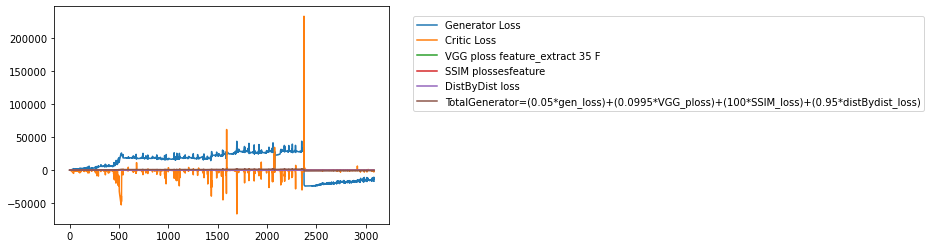

epoch :  41


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  42


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  43


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  44


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  45


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch 45:Step 69435:  Total Generator loss: -643.0937125930984, critic loss: -254.78049323274166,Generator loss: -13647.993804224574, VGG ploss mean : 9.732836469426529, SSIM loss mean : 0.28693645043722316 

Saving Fake-images-epoch0045_step69435.png

Saving Real-images-epoch0045_step69435.png


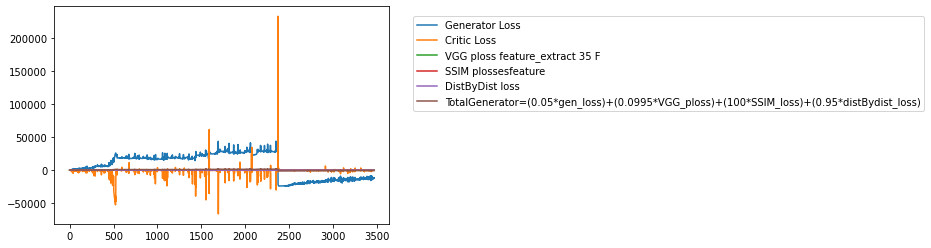

epoch :  46


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  47


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  48


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  49


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  50


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch 50:Step 77150:  Total Generator loss: -374.1678979879838, critic loss: -272.61860221956715,Generator loss: -8270.489995036492, VGG ploss mean : 9.663571732521675, SSIM loss mean : 0.28750805490911585 

Saving Fake-images-epoch0050_step77150.png

Saving Real-images-epoch0050_step77150.png


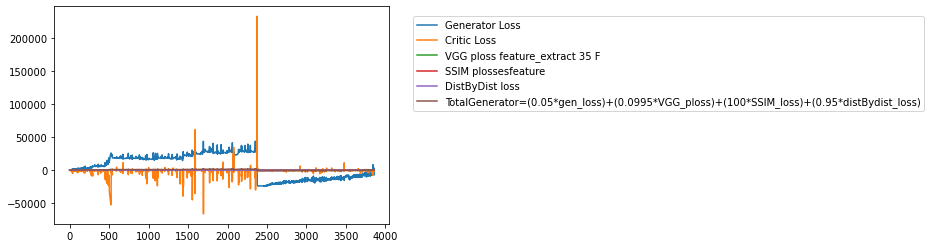

epoch :  51


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  52


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  53


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  54


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  55


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch 55:Step 84865:  Total Generator loss: -163.99844621780701, critic loss: -285.99927529759645,Generator loss: -4065.4050480469896, VGG ploss mean : 9.572233014221093, SSIM loss mean : 0.2867103761770628 

Saving Fake-images-epoch0055_step84865.png

Saving Real-images-epoch0055_step84865.png


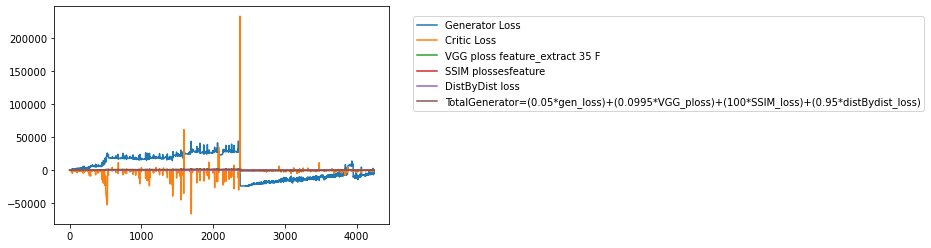

epoch :  56


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  57


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  58


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  59


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  60


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch 60:Step 92580:  Total Generator loss: -74.20760925636613, critic loss: -339.2119828467689,Generator loss: -2270.538055620546, VGG ploss mean : 9.574120614007937, SSIM loss mean : 0.2872033180467355 

Saving Fake-images-epoch0060_step92580.png

Saving Real-images-epoch0060_step92580.png


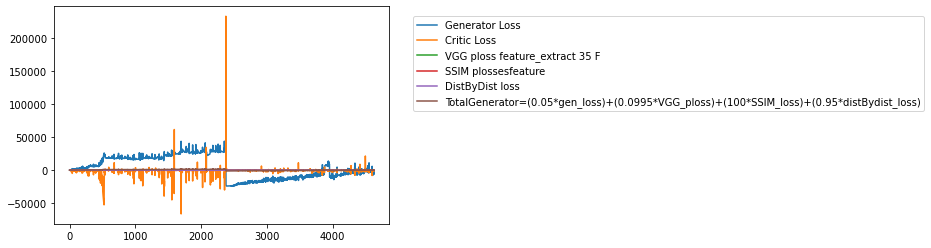

epoch :  61


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  62


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  63


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  64


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  65


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch 65:Step 100295:  Total Generator loss: -220.16441455873203, critic loss: -259.10599657385137,Generator loss: -5190.298137706267, VGG ploss mean : 9.531454790403375, SSIM loss mean : 0.2875588372784316 

Saving Fake-images-epoch0065_step100295.png

Saving Real-images-epoch0065_step100295.png


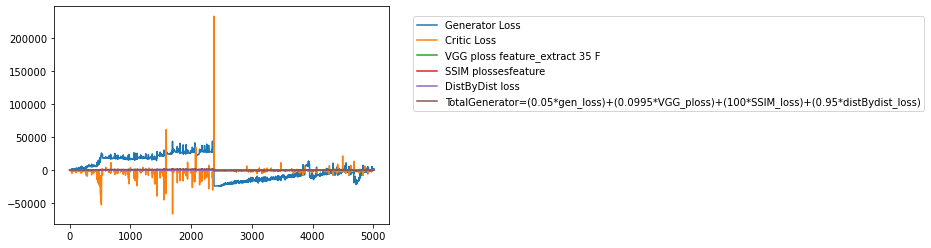

epoch :  66


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  67


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  68


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  69


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  70


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch 70:Step 108010:  Total Generator loss: 211.95165666702576, critic loss: -403.3874704418926,Generator loss: 3450.419865340346, VGG ploss mean : 9.660387385548205, SSIM loss mean : 0.2879354517257453 

Saving Fake-images-epoch0070_step108010.png

Saving Real-images-epoch0070_step108010.png


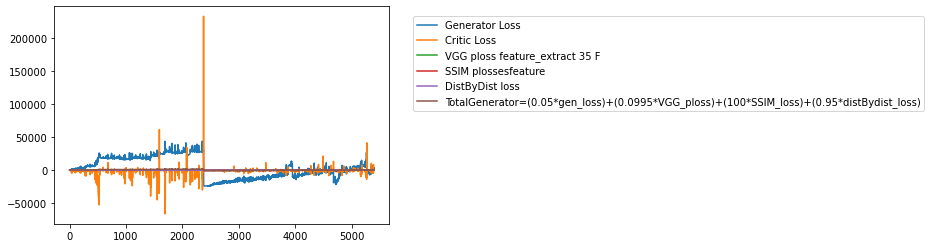

epoch :  71


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  72


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  73


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  74


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  75


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch 75:Step 115725:  Total Generator loss: 169.82650703632902, critic loss: -552.1501334989031,Generator loss: 2607.193340699053, VGG ploss mean : 9.586420121999508, SSIM loss mean : 0.2885196649556954 

Saving Fake-images-epoch0075_step115725.png

Saving Real-images-epoch0075_step115725.png


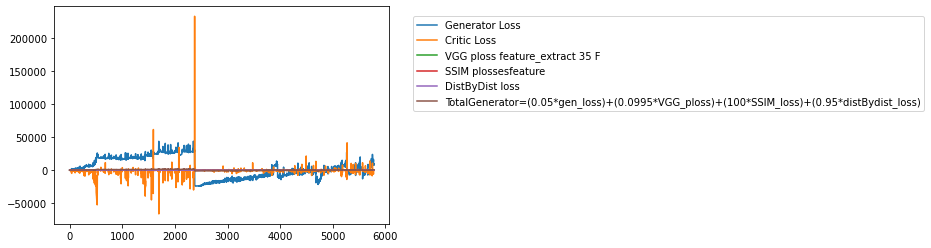

epoch :  76


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  77


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  78


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  79


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  80


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch 80:Step 123440:  Total Generator loss: -109.59123476885081, critic loss: -490.1721341497165,Generator loss: -2977.513010124162, VGG ploss mean : 9.491490973734036, SSIM loss mean : 0.2868928143132915 

Saving Fake-images-epoch0080_step123440.png

Saving Real-images-epoch0080_step123440.png


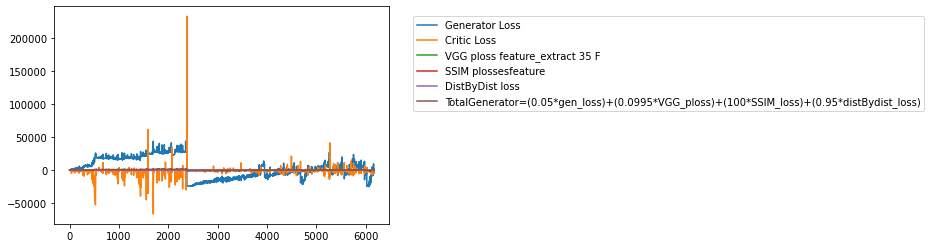

epoch :  81


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  82


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  83


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  84


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  85


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch 85:Step 131155:  Total Generator loss: 291.3606061516377, critic loss: -606.1564982239593,Generator loss: 5039.171982143672, VGG ploss mean : 9.419532881073572, SSIM loss mean : 0.2880827897335134 

Saving Fake-images-epoch0085_step131155.png

Saving Real-images-epoch0085_step131155.png


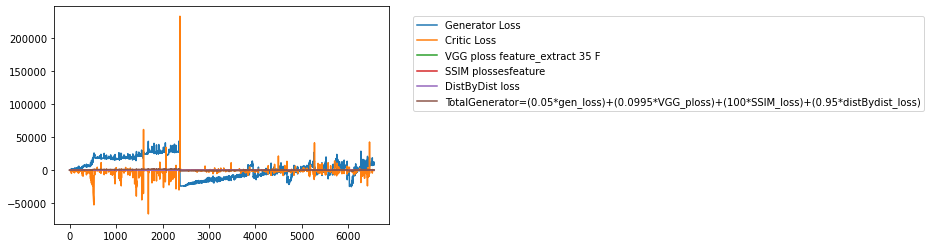

epoch :  86


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  87


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  88


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  89


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  90


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch 90:Step 138870:  Total Generator loss: -17.175829578234016, critic loss: -877.8992240948502,Generator loss: -1143.8728275442463, VGG ploss mean : 9.938078438146349, SSIM loss mean : 0.2927635429821768 

Saving Fake-images-epoch0090_step138870.png

Saving Real-images-epoch0090_step138870.png


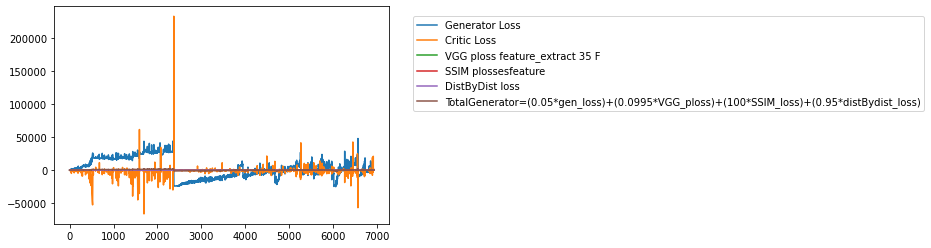

epoch :  91


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  92


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  93


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  94


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  95


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch 95:Step 146585:  Total Generator loss: -79.77000755203751, critic loss: -969.9414460160828,Generator loss: -2390.149339122488, VGG ploss mean : 9.830193731588585, SSIM loss mean : 0.29068183114755797 

Saving Fake-images-epoch0095_step146585.png

Saving Real-images-epoch0095_step146585.png


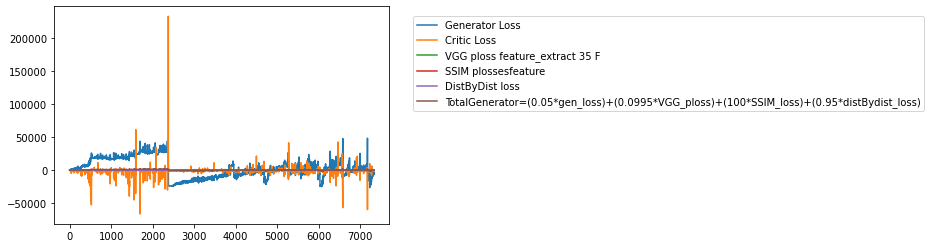

epoch :  96


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  97


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  98


  0%|          | 0/1543 [00:00<?, ?it/s]

epoch :  99


  0%|          | 0/1543 [00:00<?, ?it/s]

start 2021-12-18 03:34:07.652788
total time consumed in 100 epoch 128aa batch size 128 __ H  1 day, 17:37:09.441979


In [34]:
import matplotlib.pyplot as plt
from datetime import datetime
start = datetime.now()
print("start",start)


cur_step = 0
generator_losses = []
critic_losses = []

Total_generator_losses = []
VGG_plosses = []
SSIM_plosses = []
DistByDist_losses = []

for epoch in tqdm(range(n_epochs)):
    print("epoch : ",epoch)
    for real in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.reshape(real.shape[0],1,image_size,image_size).to(device,dtype=torch.float32)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)
        
        
        
        gen_loss = get_gen_loss(crit_fake_pred)
        
        VGG_ploss=p_loss( fake_2, real) 
        SSIM_loss= 1-pytorch_msssim.ssim( fake_2, real) 
        DistByDist_loss=DistByDist_criterion( fake_2, real)
        Total_gen_loss = (parGLoss*gen_loss) +(parVGGLoss*VGG_ploss)+ (parSSIMLoss*SSIM_loss)+(parDistByDistLoss*DistByDist_loss) 
        Total_gen_loss.backward()  
        gen_opt.step()
        generator_losses += [gen_loss.item()]
        
        
        VGG_plosses += [VGG_ploss.item()]###################
        SSIM_plosses += [SSIM_loss.item()]
        Total_generator_losses += [Total_gen_loss.item()]
        DistByDist_losses += [DistByDist_loss.item()]
                
        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step  
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            
            vgg_mean = sum(VGG_plosses[-display_step:]) / display_step###################
            ssim_mean = sum(SSIM_plosses[-display_step:]) / display_step
            total_gen_mean = sum(Total_generator_losses[-display_step:]) / display_step
            DistByDist_mean= sum(DistByDist_losses[-display_step:]) / display_step
            
            
            print(f"epoch {epoch}:Step {cur_step}:  Total Generator loss: {total_gen_mean}, critic loss: {crit_mean},Generator loss: {gen_mean}, VGG ploss mean : {vgg_mean}, SSIM loss mean : {ssim_mean} ")#,DistByDist loss mean : {DistByDist_mean}
            show_tensor_images(epoch,cur_step,fake_2,RealOrFake=False)
            show_tensor_images(epoch,cur_step,real,RealOrFake=True)
            
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(VGG_plosses[:num_examples]).view(-1, step_bins).mean(1),
                label="VGG ploss feature_extract 35 F "
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(SSIM_plosses[:num_examples]).view(-1, step_bins).mean(1),
                label="SSIM plossesfeature "
            )
            plt.plot( range(num_examples // step_bins),  torch.Tensor(DistByDist_losses[:num_examples]).view(-1, step_bins).mean(1), label="DistByDist loss ")
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(Total_generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label='TotalGenerator=('+str((parGLoss))+'*gen_loss)+('+str((parVGGLoss))+'*VGG_ploss)+('+str((parSSIMLoss))+'*SSIM_loss)+('+str((parDistByDistLoss))+'*distBydist_loss)'
            )
            #plt.legend()
            plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", borderaxespad=1)
            plt.show()

        cur_step += 1
    if((epoch+1)%5==0):#parDistByDistLoss
        torch.save(gen.state_dict(),  pathOfmodel+'/model_'+str((epoch+1))+'_epoch_'+str((parGLoss))+'_GL_'+str((parVGGLoss))+'_VGG_'+str((parSSIMLoss))+'_SSIM_'+str((parDistByDistLoss))+'_DistByDist__G.pth')
        torch.save(crit.state_dict(), pathOfmodel+'/model_'+str((epoch+1))+'_epoch_'+str((parGLoss))+'_GL_'+str((parVGGLoss))+'_VGG_'+str((parSSIMLoss))+'_SSIM_'+str((parDistByDistLoss))+'_DistByDist__C.pth')

end = datetime.now()
print("start",end)
print(f"total time consumed in {n_epochs} epoch 128aa batch size 128 __ H ",end-start)

test 100 epoch  128AA
torch.Size([64, 1, 128, 128])
avg peptide bond BackBone protien for batch tensor(3.0389)
avg peptide bond short protien for batch tensor(6.4932)
avg peptide bond Long protien for batch tensor(18.0165)


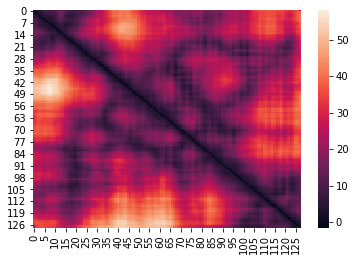

In [37]:
print(f"test {n_epochs} epoch  128AA")
with torch.no_grad():
    fake_images_test = gen(torch.randn(batch_size, 100, 1, 1, dtype=torch.float,device=device)).to("cpu")
    print(fake_images_test.shape)
    show_image(fake_images_test,index=3)
    ckeckBackBone(fake_images_test,image_size=image_size,batch_size=batch_size)
    ckeckshort(fake_images_test,image_size=image_size,batch_size=batch_size)
    ckeckLong(fake_images_test,image_size=image_size,batch_size=batch_size)
    #Bhattacharyya(torch.tensor(Tx).reshape(128,1,128,128),fake_images_test)

test3 100 epoch  128aa_H
torch.Size([64, 1, 128, 128])
avg peptide bond BackBone protien for batch tensor(2.9982)
avg peptide bond short protien for batch tensor(6.3618)
avg peptide bond Long protien for batch tensor(18.1445)


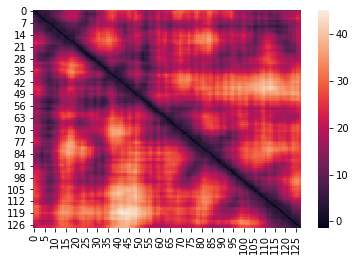

In [66]:
print(f"test3 {n_epochs} epoch  128aa_H")
with torch.no_grad():
    fake_images_test = gen(torch.randn(batch_size, 100, 1, 1, dtype=torch.float,device=device)).to("cpu")
    print(fake_images_test.shape)
    show_image(fake_images_test,index=3)
    ckeckBackBone(fake_images_test,image_size=image_size,batch_size=batch_size)
    ckeckshort(fake_images_test,image_size=image_size,batch_size=batch_size)
    ckeckLong(fake_images_test,image_size=image_size,batch_size=batch_size)
    #Bhattacharyya(torch.tensor(Tx).reshape(128,1,128,128),fake_images_test)

test 100 epoch  128AA
torch.Size([128, 1, 128, 128])
avg peptide bond BackBone protien for batch tensor(3.1919)
avg peptide bond short protien for batch tensor(6.3141)
avg peptide bond Long protien for batch tensor(18.0667)


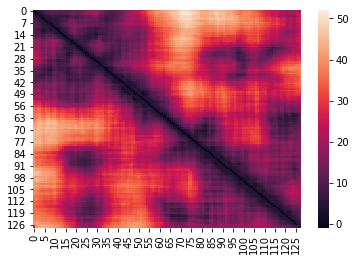

In [36]:
print(f"test {n_epochs} epoch  128AA")
with torch.no_grad():
    fake_images_test = gen(torch.randn(batch_size, 100, 1, 1, dtype=torch.float,device=device)).to("cpu")
    print(fake_images_test.shape)
    show_image(fake_images_test,index=3)
    ckeckBackBone(fake_images_test,image_size=image_size,batch_size=batch_size)
    ckeckshort(fake_images_test,image_size=image_size,batch_size=batch_size)
    ckeckLong(fake_images_test,image_size=image_size,batch_size=batch_size)
    #Bhattacharyya(torch.tensor(Tx).reshape(128,1,128,128),fake_images_test)

test 100 epoch  128AA
torch.Size([128, 1, 128, 128])
avg peptide bond BackBone protien for batch tensor(3.2453)
avg peptide bond short protien for batch tensor(6.3308)
avg peptide bond Long protien for batch tensor(18.1627)


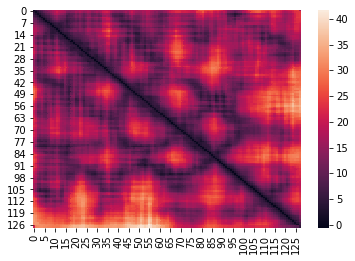

In [37]:
print(f"test {n_epochs} epoch  128AA")
with torch.no_grad():
    fake_images_test = gen(torch.randn(batch_size, 100, 1, 1, dtype=torch.float,device=device)).to("cpu")
    print(fake_images_test.shape)
    show_image(fake_images_test,index=3)
    ckeckBackBone(fake_images_test,image_size=image_size,batch_size=batch_size)
    ckeckshort(fake_images_test,image_size=image_size,batch_size=batch_size)
    ckeckLong(fake_images_test,image_size=image_size,batch_size=batch_size)
    #Bhattacharyya(torch.tensor(Tx).reshape(128,1,128,128),fake_images_test)

test2 100 epoch  128aa
torch.Size([128, 1, 128, 128])
avg peptide bond BackBone protien for batch tensor(3.2012)
avg peptide bond short protien for batch tensor(6.2863)
avg peptide bond Long protien for batch tensor(18.1753)


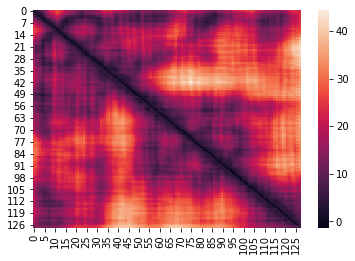

In [38]:
print(f"test2 {n_epochs} epoch  128aa")
with torch.no_grad():
    fake_images_test = gen(torch.randn(batch_size, 100, 1, 1, dtype=torch.float,device=device)).to("cpu")
    print(fake_images_test.shape)
    show_image(fake_images_test,index=3)
    ckeckBackBone(fake_images_test,image_size=image_size,batch_size=batch_size)
    ckeckshort(fake_images_test,image_size=image_size,batch_size=batch_size)
    ckeckLong(fake_images_test,image_size=image_size,batch_size=batch_size)
    #Bhattacharyya(torch.tensor(Tx).reshape(128,1,128,128),fake_images_test)

test 10 epoch  
torch.Size([64, 1, 128, 128])
avg peptide bond BackBone protien for batch tensor(2.7113)
avg peptide bond short protien for batch tensor(6.0454)
avg peptide bond Long protien for batch tensor(18.2821)


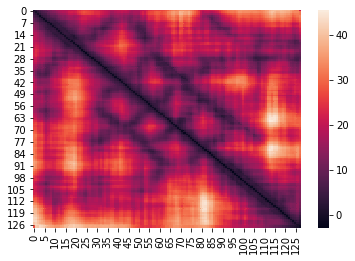

In [45]:
print(f"test {n_epochs} epoch  ")
with torch.no_grad():
    fake_images_test = gen(torch.randn(batch_size, 100, 1, 1, dtype=torch.float,device=device)).to("cpu")
    print(fake_images_test.shape)
    show_image(fake_images_test,index=3)
    ckeckBackBone(fake_images_test,image_size=image_size,batch_size=batch_size)
    ckeckshort(fake_images_test,image_size=image_size,batch_size=batch_size)
    ckeckLong(fake_images_test,image_size=image_size,batch_size=batch_size)
    #Bhattacharyya(torch.tensor(Tx).reshape(128,1,128,128),fake_images_test)

test 20 epoch  
torch.Size([32, 1, 256, 256])
avg peptide bond BackBone protien for batch tensor(3.4605)
avg peptide bond short protien for batch tensor(6.1764)
avg peptide bond Long protien for batch tensor(21.0845)


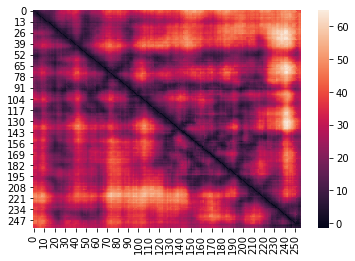

In [38]:
print(f"test {n_epochs} epoch  ")
with torch.no_grad():
    fake_images_test = gen(torch.randn(batch_size, 100, 1, 1, dtype=torch.float,device=device)).to("cpu")
    print(fake_images_test.shape)
    show_image(fake_images_test,index=3)
    ckeckBackBone(fake_images_test,image_size=256,batch_size=batch_size)
    ckeckshort(fake_images_test,image_size=256,batch_size=batch_size)
    ckeckLong(fake_images_test,image_size=256,batch_size=batch_size)
    #Bhattacharyya(torch.tensor(Tx).reshape(128,1,128,128),fake_images_test)
    

test 20 epoch  
torch.Size([32, 1, 256, 256])
avg peptide bond BackBone protien for batch tensor(3.3979)
avg peptide bond short protien for batch tensor(6.1232)
avg peptide bond Long protien for batch tensor(20.9893)


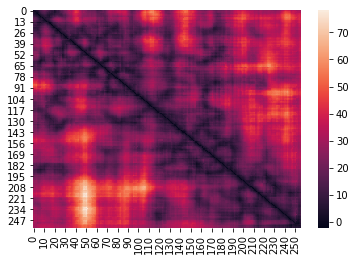

In [39]:
print(f"test {n_epochs} epoch  ")
with torch.no_grad():
    fake_images_test = gen(torch.randn(batch_size, 100, 1, 1, dtype=torch.float,device=device)).to("cpu")
    print(fake_images_test.shape)
    show_image(fake_images_test,index=3)
    ckeckBackBone(fake_images_test,image_size=256,batch_size=batch_size)
    ckeckshort(fake_images_test,image_size=256,batch_size=batch_size)
    ckeckLong(fake_images_test,image_size=256,batch_size=batch_size)
    #Bhattacharyya(torch.tensor(Tx).reshape(128,1,128,128),fake_images_test)
    

test2 40 epoch  
torch.Size([32, 1, 256, 256])
avg peptide bond BackBone protien for batch tensor(3.9803)
avg peptide bond short protien for batch tensor(7.5381)
avg peptide bond Long protien for batch tensor(22.0072)


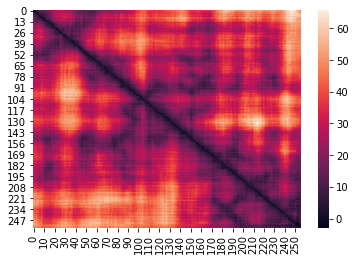

In [47]:
print(f"test2 {n_epochs} epoch  ")
with torch.no_grad():
    fake_images_test = gen(torch.randn(batch_size, 100, 1, 1, dtype=torch.float,device=device)).to("cpu")
    print(fake_images_test.shape)
    show_image(fake_images_test,index=3)
    ckeckBackBone(fake_images_test,image_size=256,batch_size=batch_size)
    ckeckshort(fake_images_test,image_size=256,batch_size=batch_size)
    ckeckLong(fake_images_test,image_size=256,batch_size=batch_size)
    #Bhattacharyya(torch.tensor(Tx).reshape(128,1,128,128),fake_images_test)
    

test 50 epoch  
torch.Size([32, 1, 256, 256])
avg peptide bond BackBone protien for batch tensor(3.3408)
avg peptide bond short protien for batch tensor(6.3663)
avg peptide bond Long protien for batch tensor(22.9074)


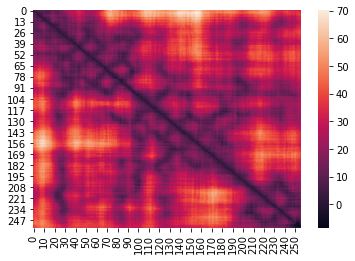

In [52]:
print(f"test {n_epochs} epoch  ")
with torch.no_grad():
    fake_images_test = gen(torch.randn(batch_size, 100, 1, 1, dtype=torch.float,device=device)).to("cpu")
    print(fake_images_test.shape)
    show_image(fake_images_test,index=3)
    ckeckBackBone(fake_images_test,image_size=256,batch_size=batch_size)
    ckeckshort(fake_images_test,image_size=256,batch_size=batch_size)
    ckeckLong(fake_images_test,image_size=256,batch_size=batch_size)
    #Bhattacharyya(torch.tensor(Tx).reshape(128,1,128,128),fake_images_test)
    

test 10 epoch (0.05*gen_loss) +(0.0995*VGG_ploss)+ (100*SSIM_loss)+(0.95*Sharp_loss) 
torch.Size([128, 1, 128, 128])
avg peptide bond BackBone protien for batch tensor(3.4232)
avg peptide bond short protien for batch tensor(6.4256)
avg peptide bond Long protien for batch tensor(18.1950)
tensor(0.9569, dtype=torch.float64)


tensor(1.0441, dtype=torch.float64)

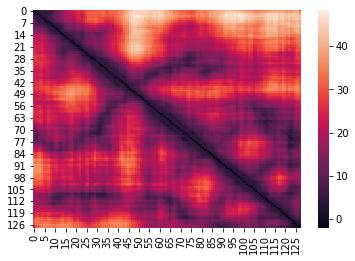

In [20]:
print(f"test {n_epochs} epoch ({parGLoss}*gen_loss) +({parVGGLoss}*VGG_ploss)+ ({parSSIMLoss}*SSIM_loss)+({parSharpLoss}*Sharp_loss) ")
with torch.no_grad():
    fake_images_test = gen(torch.randn(128, 100, 1, 1, dtype=torch.float,device=device)).to("cpu")
    print(fake_images_test.shape)
    show_image(fake_images_test,index=3)
ckeckBackBone(fake_images_test,image_size=128,batch_size=128)
ckeckshort(fake_images_test,image_size=128,batch_size=128)
ckeckLong(fake_images_test,image_size=128,batch_size=128)
Bhattacharyya(torch.tensor(Tx).reshape(128,1,128,128),fake_images_test)

test2 10 epoch  (0.5*gen_loss)+(0.95*VGG_ploss)+(0.95*SSIM_loss)+(0.95*Sharp_loss)
torch.Size([128, 1, 128, 128])
avg peptide bond BackBone protien for batch tensor(3.4222)
avg peptide bond short protien for batch tensor(6.5792)
avg peptide bond Long protien for batch tensor(17.8630)
tensor(0.9583, dtype=torch.float64)


tensor(1.0426, dtype=torch.float64)

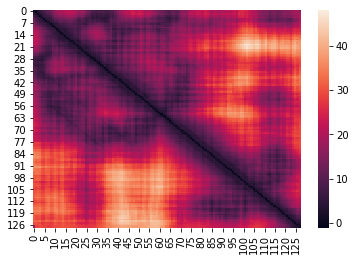

In [28]:
print("test2 10 epoch  (0.5*gen_loss)+(0.95*VGG_ploss)+(0.95*SSIM_loss)+(0.95*Sharp_loss)")
with torch.no_grad():
    fake_images_test2 = gen(torch.randn(128, 100, 1, 1, dtype=torch.float,device=device)).to("cpu")
    print(fake_images_test2.shape)
    show_image(fake_images_test2,index=3)
ckeckBackBone(fake_images_test2,image_size=128,batch_size=128)
ckeckshort(fake_images_test2,image_size=128,batch_size=128)
ckeckLong(fake_images_test2,image_size=128,batch_size=128)
Bhattacharyya(torch.tensor(Tx).reshape(128,1,128,128),fake_images_test2)

test1 10 epoch  (0.05*gen_loss)+(0.95*VGG_ploss)+(0.95*SSIM_loss)+(0.95*Sharp_loss)


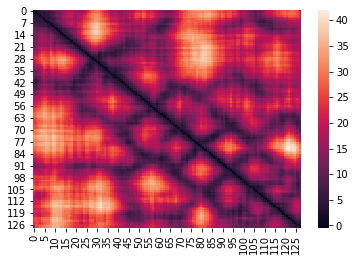

In [31]:
print("test1 10 epoch  (0.05*gen_loss)+(0.95*VGG_ploss)+(0.95*SSIM_loss)+(0.95*Sharp_loss)")

show_image(fake_images_test,index=1)


test2s 10 epoch  (0.5*gen_loss)+(0.95*VGG_ploss)+(0.95*SSIM_loss)+(0.5*Sharp_loss)
torch.Size([128, 1, 128, 128])
avg peptide bond BackBone protien for batch tensor(3.1389)
avg peptide bond short protien for batch tensor(6.3931)
avg peptide bond Long protien for batch tensor(17.4063)
tensor(0.9576, dtype=torch.float64)


tensor(1.0434, dtype=torch.float64)

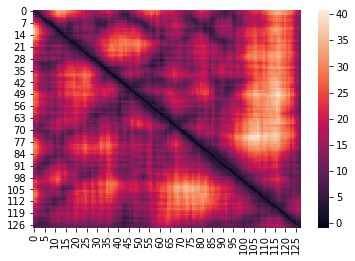

In [35]:
print("test2s 10 epoch  (0.5*gen_loss)+(0.95*VGG_ploss)+(0.95*SSIM_loss)+(0.5*Sharp_loss)")
with torch.no_grad():
    fake_images_test2s = gen(torch.randn(128, 100, 1, 1, dtype=torch.float,device=device)).to("cpu")
    print(fake_images_test2s.shape)
    show_image(fake_images_test2s,index=3)
ckeckBackBone(fake_images_test2s,image_size=128,batch_size=128)
ckeckshort(fake_images_test2s,image_size=128,batch_size=128)
ckeckLong(fake_images_test2s,image_size=128,batch_size=128)
Bhattacharyya(torch.tensor(Tx).reshape(128,1,128,128),fake_images_test2s)

In [23]:
with h5py.File(data_path, "r") as data_file:
    Tx = data_file[f"train_{image_size}"][:128]
print("test 100 epoch")
ckeckBackBone(fake_images_test,image_size=128,batch_size=128)
ckeckshort(fake_images_test,image_size=128,batch_size=128)
ckeckLong(fake_images_test,image_size=128,batch_size=128)
Bhattacharyya(torch.tensor(Tx).reshape(128,1,128,128),fake_images_test)

test 100 epoch
avg peptide bond BackBone protien for batch tensor(3.4088)
avg peptide bond short protien for batch tensor(6.6512)
avg peptide bond Long protien for batch tensor(19.3434)
tensor(0.9571, dtype=torch.float64)


tensor(1.0438, dtype=torch.float64)

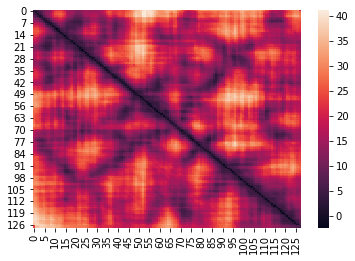

In [25]:
show_image(fake_images_test2,index=3)

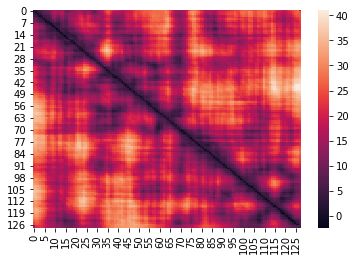

In [28]:
show_image(fake_images_test2,index=2)

In [24]:
print("test 100 epoch Try2 ")
with torch.no_grad():
    fake_images_test2 = gen(torch.randn(128, 100, 1, 1, dtype=torch.float,device=device)).to("cpu")
    ckeckBackBone(fake_images_test2,image_size=128,batch_size=128)
    ckeckshort(fake_images_test2,image_size=128,batch_size=128)
    ckeckLong(fake_images_test2,image_size=128,batch_size=128)
    Bhattacharyya(torch.tensor(Tx).reshape(128,1,128,128),fake_images_test2)

test 100 epoch Try2 
avg peptide bond BackBone protien for batch tensor(3.4790)
avg peptide bond short protien for batch tensor(6.7442)
avg peptide bond Long protien for batch tensor(19.3326)
tensor(0.9577, dtype=torch.float64)


test 50 epoch
torch.Size([128, 1, 128, 128])


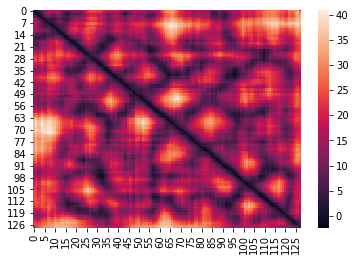

In [19]:
print("test 50 epoch")
with torch.no_grad():
    fake_images_test = gen(torch.randn(128, 100, 1, 1, dtype=torch.float,device=device)).to("cpu")
    print(fake_images_test.shape)
    show_image(fake_images_test,index=2)

test 50 epoch try2
torch.Size([128, 1, 128, 128])
avg peptide bond BackBone protien for batch tensor(2.7755)
avg peptide bond short protien for batch tensor(6.4337)
avg peptide bond Long protien for batch tensor(18.0309)
tensor(0.9543, dtype=torch.float64)


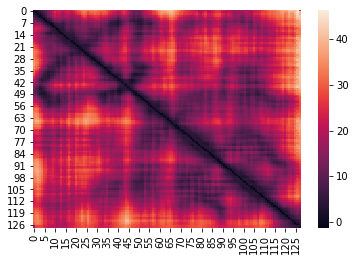

In [21]:
print("test 50 epoch try2")
with torch.no_grad():
    fake_images_test2 = gen(torch.randn(128, 100, 1, 1, dtype=torch.float,device=device)).to("cpu")
    print(fake_images_test2.shape)
    show_image(fake_images_test2,index=2)
    ckeckBackBone(fake_images_test2,image_size=128,batch_size=128)
    ckeckshort(fake_images_test2,image_size=128,batch_size=128)
    ckeckLong(fake_images_test2,image_size=128,batch_size=128)
    Bhattacharyya(torch.tensor(Tx).reshape(128,1,128,128),fake_images_test2)